**Imports and Setup**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# Set visualization style
sns.set(style="whitegrid")
# Display all columns
pd.set_option('display.max_columns', None)

print("Libraries loaded successfully.")

Libraries loaded successfully.


**Load the dataset**

In [3]:
# Load the dataset
# Make sure 'SuperMarket Analysis.csv' is in the same directory
df = pd.read_csv('SuperMarket Analysis.csv')

# Display basic info
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())
print("\nData Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (1000, 17)

First 5 rows:


,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Sales,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,Alex,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,1:08:00 PM,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,Giza,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29:00 AM,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,Alex,Yangon,Normal,Female,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,1:23:00 PM,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,Alex,Yangon,Member,Female,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,8:33:00 PM,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,Alex,Yangon,Member,Female,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37:00 AM,Ewallet,604.17,4.761905,30.2085,5.3



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Tax 5%                   1000 non-null   float64
 9   Sales                    1000 non-null   float64
 10  Date                     1000 non-null   object 
 11  Time                     1000 non-null   object 
 12  Payment                  1000 non-null   object 
 13  cogs                     1000 non-null   float64
 14  gross margin 

**Data Preprocessing (Date & Time)**

In [4]:
# # Convert Date column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Extract features from Date and Time
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Hour'] = pd.to_datetime(df['Time']).dt.hour

# Check the new columns
print(df[['Date', 'Month', 'Day', 'Time', 'Hour']].head())
df['Date'] = pd.to_datetime(df['Date'])

# Extract features from Date and Time
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Hour'] = pd.to_datetime(df['Time']).dt.hour

# Check the new columns
print(df[['Date', 'Month', 'Day', 'Time', 'Hour']].head())

        Date  Month  Day         Time  Hour
0 2019-01-05      1    5   1:08:00 PM    13
1 2019-03-08      3    8  10:29:00 AM    10
2 2019-03-03      3    3   1:23:00 PM    13
3 2019-01-27      1   27   8:33:00 PM    20
4 2019-02-08      2    8  10:37:00 AM    10
        Date  Month  Day         Time  Hour
0 2019-01-05      1    5   1:08:00 PM    13
1 2019-03-08      3    8  10:29:00 AM    10
2 2019-03-03      3    3   1:23:00 PM    13
3 2019-01-27      1   27   8:33:00 PM    20
4 2019-02-08      2    8  10:37:00 AM    10


/tmp/ipython-input-3205393531.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Hour'] = pd.to_datetime(df['Time']).dt.hour
/tmp/ipython-input-3205393531.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Hour'] = pd.to_datetime(df['Time']).dt.hour


**Exploratory Data Analysis (EDA)**

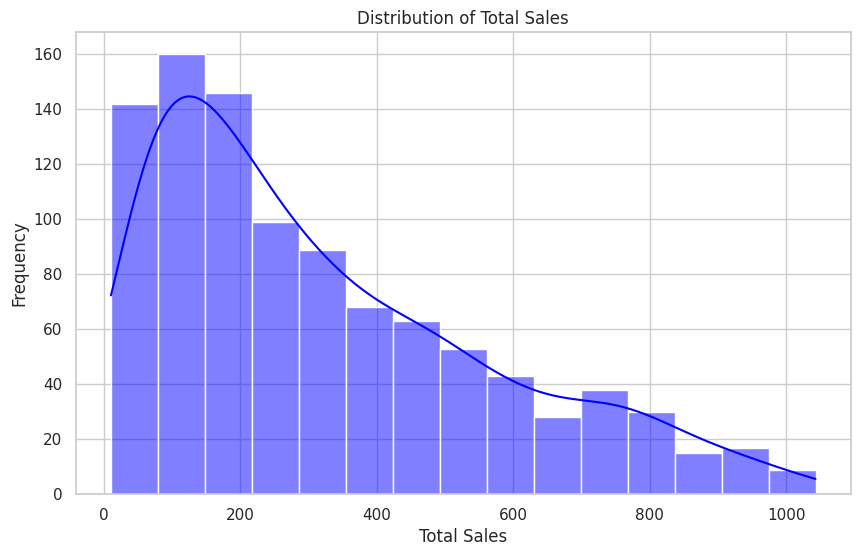

/tmp/ipython-input-4144739115.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Product line', y='Sales', data=df, palette="Set2")


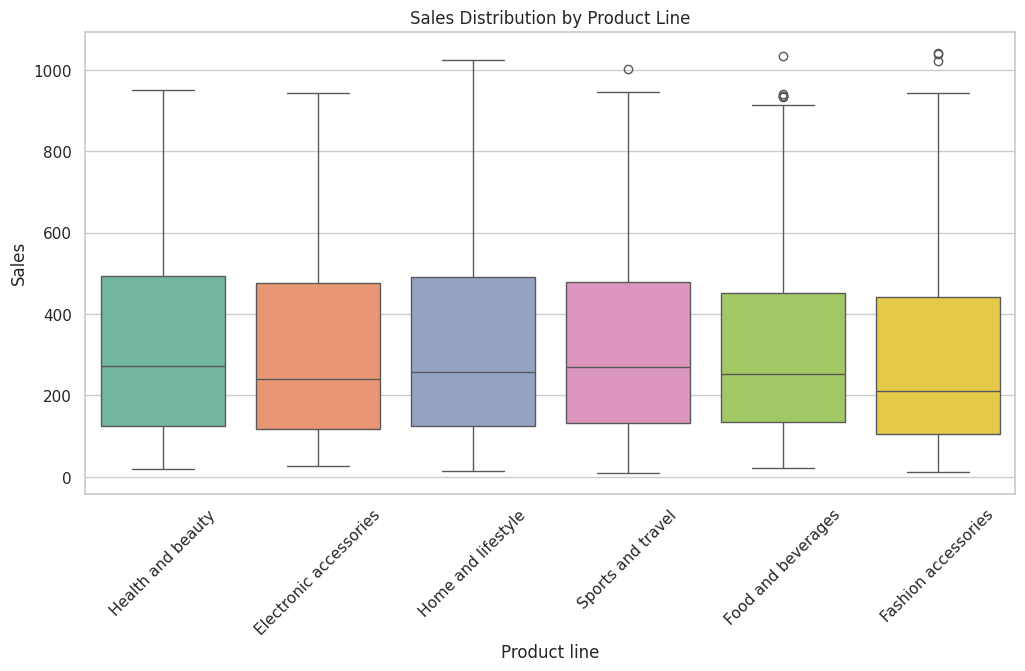

/tmp/ipython-input-4144739115.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Branch', y='Sales', data=df, palette="viridis", ci=None)
/tmp/ipython-input-4144739115.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Branch', y='Sales', data=df, palette="viridis", ci=None)


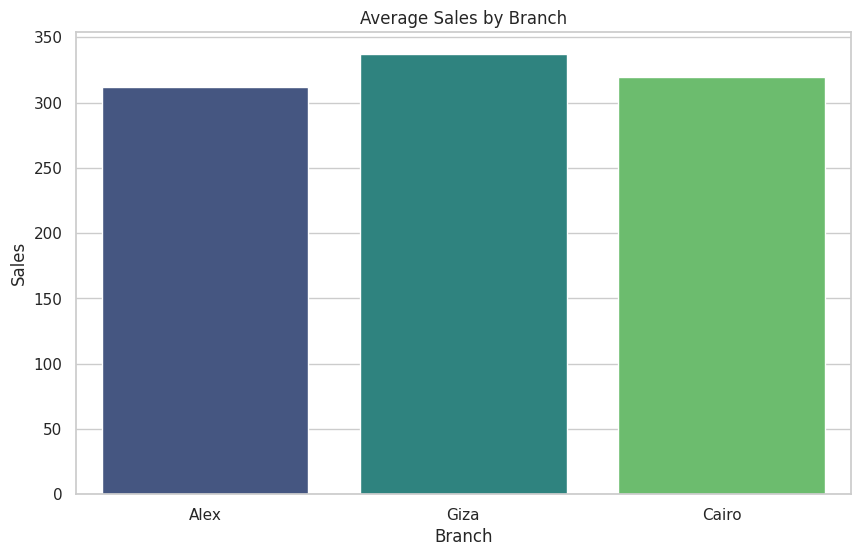

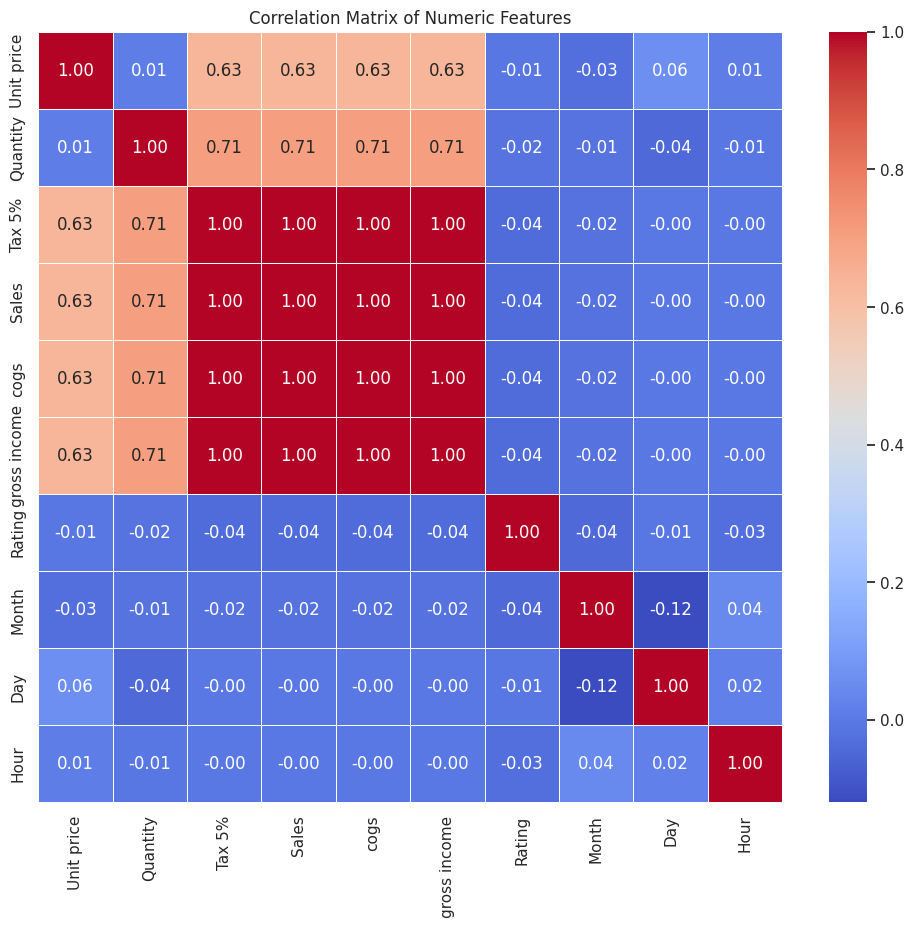

/tmp/ipython-input-4144739115.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Month', y='Sales', data=monthly_sales, palette="magma")


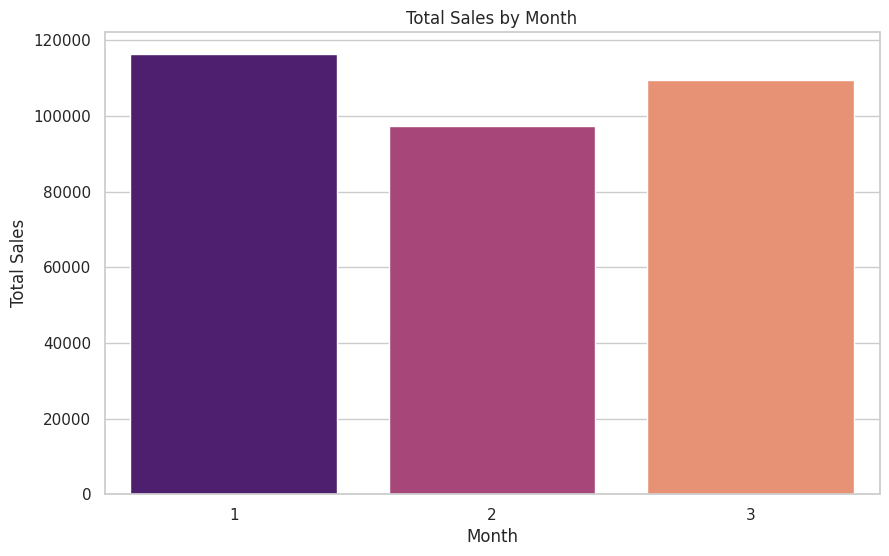

In [5]:
# 1. Distribution of Total Sales
plt.figure(figsize=(10, 6))
sns.histplot(df['Sales'], kde=True, color='blue')
plt.title('Distribution of Total Sales')
plt.xlabel('Total Sales')
plt.ylabel('Frequency')
plt.show()

# 2. Sales by Product Line (Boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(x='Product line', y='Sales', data=df, palette="Set2")
plt.xticks(rotation=45)
plt.title('Sales Distribution by Product Line')
plt.show()

# 3. Average Sales by Branch
plt.figure(figsize=(10, 6))
# We use ci=None to remove error bars for a cleaner look at the mean
sns.barplot(x='Branch', y='Sales', data=df, palette="viridis", ci=None)
plt.title('Average Sales by Branch')
plt.show()

# 4. Correlation Matrix
# Select only numeric columns and drop the constant 'gross margin percentage'
numeric_cols = df.select_dtypes(include=[np.number]).drop(['gross margin percentage'], axis=1, errors='ignore')

plt.figure(figsize=(12, 10))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

# 5. Total Sales by Month
monthly_sales = df.groupby('Month')['Sales'].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='Month', y='Sales', data=monthly_sales, palette="magma")
plt.title('Total Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

**Feature Engineering & Data Splitting**

In [6]:
# Define Features (X) and Target (y)
# We drop columns that are direct calculators of Sales (Tax, COGS, Gross Income) to prevent data leakage
X = df.drop(['Invoice ID', 'Tax 5%', 'Sales', 'cogs', 'gross margin percentage',
             'gross income', 'Date', 'Time'], axis=1)
y = df['Sales']

# Identify Categorical and Numerical columns
categorical_cols = ['Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Payment']
numerical_cols = ['Unit price', 'Quantity', 'Rating', 'Month', 'Day', 'Hour']

# Create the Preprocessing Pipeline
# - StandardScaler for numerical data
# - OneHotEncoder for categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ])

# Split the dataset 70% Training, 30% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (700, 12)
Testing Data Shape: (300, 12)


**Model Building & Evaluation**

In [7]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42)
}

results = {}
best_model = None
best_r2 = -np.inf

print("Model Performance Evaluation:\n")

for name, model in models.items():
    # Create a full pipeline with preprocessor and model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {'RMSE': rmse, 'R2': r2}
    print(f"{name} -> RMSE: {rmse:.2f}, R2 Score: {r2:.4f}")

    # Keep track of the best model
    if r2 > best_r2:
        best_r2 = r2
        best_model = pipeline

print(f"\nBest Performing Model: {best_model.named_steps['model']}")

Model Performance Evaluation:

Linear Regression -> RMSE: 84.02, R2 Score: 0.8929
Random Forest -> RMSE: 11.72, R2 Score: 0.9979
Decision Tree -> RMSE: 16.91, R2 Score: 0.9957

Best Performing Model: RandomForestRegressor(random_state=42)


**Feature Importance (Random Forest)**

/tmp/ipython-input-245050655.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(10), palette="viridis")


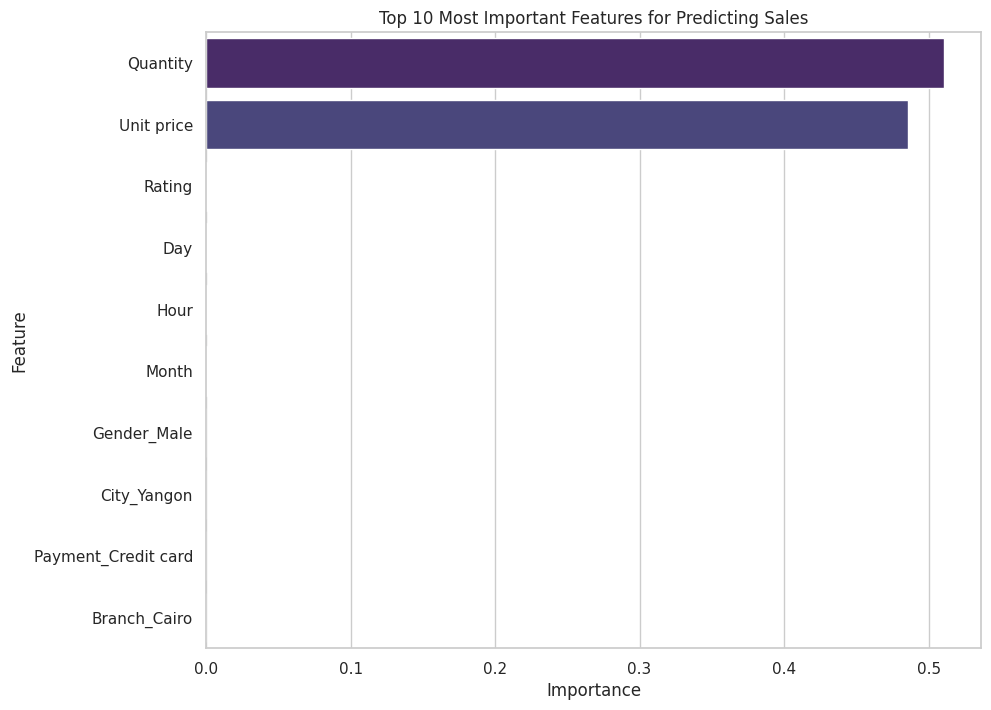

In [8]:
# Visualize Feature Importance if the best model is Random Forest
if isinstance(best_model.named_steps['model'], RandomForestRegressor):
    rf_model = best_model.named_steps['model']

    # Get encoded feature names
    ohe = best_model.named_steps['preprocessor'].named_transformers_['cat']
    feature_names = numerical_cols + list(ohe.get_feature_names_out(categorical_cols))

    # Get importance scores
    importances = rf_model.feature_importances_

    # Create a DataFrame for plotting
    feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

    # Plot
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(10), palette="viridis")
    plt.title('Top 10 Most Important Features for Predicting Sales')
    plt.show()

**Save the Model**

In [9]:
# Save the best model to a file for the Streamlit App
model_filename = 'supermarket_sales_model.pkl'
joblib.dump(best_model, model_filename)

print(f"Model saved successfully as '{model_filename}'")

Model saved successfully as 'supermarket_sales_model.pkl'
